# FloodNet Project

### From FloodNet Paper
For semantic segmentation, we implemented three methods, i.e. PSPNet [48], ENet [62], and DeepLabv3C [59]; and evaluate their performance on FloodNet dataset. For implementing PSPNet, ResNet101 was used as backbone. 

**We used ''poly'' learning rate with base learning rate 0.0001. Momentum, weight decay, power, and weight of the auxiliary loss
were set to 0.9, 0.0001, 0.9, and 0.4 respectively.**

For image augmentation we used random shuffling, scaling, flipping, and random rotation which helped the models avoid overfitting. From different experiments it was proved that larger ''crop size'' and ''batch size'' improve the performance
of the models. During training, we resized the images to 713 x 713 since large crop size is useful for the high resolution
images. 

For semantic segmentation evaluation metric, we used mean intersection over union (mIoU).

Possible Changes:
- more epochs
- weight decay, momentum
- SGD/Adam as optimizer
- different/changing learning rate
- different weights for classes
- U-Net instead of Pyramid Pooling Model
- use several GPUs

until now:
- optimizer=SGD, epochs=30, weight decay=0, batch size=2, batches per epoch=20, learning rate=0.01, weights=[0.05, 0.2, 0.2, 0.15, 0.15, 0.05, 0.05, 0.05, 0.05, 0.05]
    - trainloss 1.24, train accuracy **72.87%**, train balanced accuracy **67.17%**
    - valloss 0.89, val accuracy **67.91%**, balanced accuracy **44.45%**, Intersection over Union: [0.18827635 0.3620878  0.14774234 0.         0.53035825 0.41891271 0.         0.         0.6374796 ]
- optimizer=SGD, epochs=30, weight decay=0, batch size=2, batches per epoch=20, learning rate=0.001, weights=[0.05, 0.2, 0.2, 0.15, 0.15, 0.05, 0.05, 0.05, 0.05, 0.05]
    - trainloss 1.39, train accuracy 69.13%, train balanced accuracy 54.09%
    - valloss 1.07, val accuracy 62.63, balanced accuracy 30.05, Intersection over Union: [0.03725093 0.51092529 0.00490301 0.         0.37201954 0.41734409 0.         0.         0.56430099]
- optimizer=Adam, epochs=30, weight decay=0, batch size=2, batches per epoch=20, learning rate=0.01, weights=[0.05, 0.2, 0.2, 0.15, 0.15, 0.05, 0.05, 0.05, 0.05, 0.05]
    - trainloss 2.10, train accuracy 50.98%,    train balanced accuracy 33.58%
    - valloss 1.68, val accuracy 47.04, balanced accuracy 17.74, Intersection over Union: [0.         0.         0.         0.06583662 0.18138754 0.       0.         0.         0.50869021]
- optimizer=Adam, epochs=30, weight decay=0, batch size=2, batches per epoch=20, learning rate=0.001, weights=[0.05, 0.2, 0.2, 0.15, 0.15, 0.05, 0.05, 0.05, 0.05, 0.05]
    - trainloss 2.00, train accuracy 59.65%,    train balanced accuracy 42.45%
    - valloss 1.29, val accuracy 54.48, balanced accuracy 15.77, Intersection over Union: [0.         0.06595897 0.         0.0069809  0.         0.22147937   0.         0.         0.56374257]
- optimizer=SGD, epochs=60, weight decay=0, batch size=3, batches per epoch=20, learning rate=0.01, weights=[0.05, 0.2, 0.2, 0.15, 0.15, 0.05, 0.05, 0.05, 0.05, 0.05]
    - trainloss 1.43, train accuracy 70.90%,    train balanced accuracy 59.16%
    - valloss 0.33, val accuracy 86.01, balanced accuracy 52.66, Intersection over Union: [5.99556328e-05 8.60537974e-01 1.94983422e-01 8.19735111e-01] (epoch 56)
- optimizer=SGD, epochs=30, weight decay=0.0001, momentum=0.9, batch size=3, batches per epoch=20, learning rate=0.01, weights=[0.05, 0.2, 0.2, 0.15, 0.15, 0.05, 0.05, 0.05, 0.05, 0.05]
    - trainloss 1.53, train accuracy 63.77%,    train balanced accuracy 50.70%
    - valloss 0.69, val accuracy 86.25, balanced accuracy 61.13, Intersection over Union: [7.19746195e-01 6.84713348e-01 7.87294777e-01 1.56911972e-04 0.00000000e+00 8.33504839e-01]
- optimizer=SGD, epochs=30, weight decay=0.0001, momentum=0.9, batch size=6, batches per epoch=20, learning rate=0.01, weights=[0.05, 0.2, 0.2, 0.15, 0.15, 0.05, 0.05, 0.05, 0.05, 0.05]
    - trainloss 1.67, train accuracy 61.02%,    train balanced accuracy 41.07%
    - valloss 6.37, val accuracy 48.72, balanced accuracy 20.61, Intersection over Union: [8.31279230e-05 1.42215869e-01 0.00000000e+00 1.15059648e-02 4.80412411e-01 7.17160623e-02 0.00000000e+00 0.00000000e+00

## Imports

In [1]:
#import sys
#!pip install mlxtend

In [2]:
from PIL import Image
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import cv2

from torch import nn
import torch.nn.functional as F
#import model.resnet as models

from torch.optim import SGD

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, jaccard_score
from mlxtend.plotting import plot_confusion_matrix

import time

In [3]:
#if mean and standard deviation for training sample should be recomputed
RECOMPUTE_MEAN_STD = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Dataset

In [4]:
#helper function
#code in this cell from https://albumentations.ai/docs/examples/example_kaggle_salt/
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

In [5]:
class FloodData(Dataset):

    # mapping between label class names and indices
    LABEL_CLASSES = {
      'background': 		  0,
      'building-flooded': 			    1,
      'building-non-flooded': 	  2,
      'road-flooded': 				      3,
      'road-non-flooded': 			    4,
      'water': 			    5,
      'tree':   6,
      'vehicle': 				    7,
      'pool': 				    8,
      'grass': 			  9
    }
   

    def __init__(self, transforms=None, split='train'):
        
        self.transforms = transforms
        
        SPLIT = pd.read_csv("FloodNet_split_train_valid_test.csv", sep=',', header=None, names=["Column1", "Column2", "Column3"])
        SPLIT["Column1"] = SPLIT["Column1"].map(lambda x: "data/image/" + x)
        SPLIT["Column2"] = SPLIT["Column2"].map(lambda x: "data/mask/" + x)
        
        splitted_set = SPLIT[SPLIT["Column3"]==split]
        
        # prepare data
        self.data = list(zip(splitted_set["Column1"], splitted_set["Column2"]))                                  # list of tuples of (image path, label class)
        """
        images = np.empty((len(self.data)*3000,len(self.data)*4000,3))
        
        for i in range(len(self.data)):
            images[i] = np.array()
            Image.open()
        """ 
            
    #TODO: please provide the remaining functions required for the torch.utils.data.Dataset class.
    def __len__(self):
        return len(self.data)


    def __getitem__(self, x):
        imgName, labelsName = self.data[x]

        img = np.array(Image.open(imgName))
        labels = np.array(Image.open(labelsName))
        if self.transforms is not None:
            transformed = self.transforms(image=img, mask=labels)
            #code to visualize transformation - uncomment if want to use
            #visualize(transformed["image"], transformed["mask"], img, labels)
            img = transformed['image']
            labels = transformed['mask']
        else:
            img, labels = img[:3000, :4000,:], labels[:3000, :4000]
        
        img, labels = torch.tensor(img).float(), torch.tensor(labels).long()
        #move band dimension to the first dimension, because it is expected like this in the model
        img = torch.movedim(img, 2, 0)

        return img, labels


In [6]:
# source of code in this cell:
# https://www.binarystudy.com/2021/04/how-to-calculate-mean-standard-deviation-images-pytorch.html

def batch_mean_and_sd(loader):
    count = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)
    
    for images, _  in tqdm(loader):
        b, c, h, w = images.shape #batch, color, height, width
        nb_pixels = b*h*w
        
        sum_ = torch.sum(images, dim = [0,2,3])
        sum_of_square = torch.sum(torch.square(images), dim = [0,2,3])
        
        fst_moment = (count*fst_moment+sum_)/(count+nb_pixels)
        snd_moment = (count*snd_moment+sum_of_square)/(count+nb_pixels)

        count += nb_pixels
        
    mean, std = fst_moment, torch.sqrt(snd_moment-fst_moment**2)
    return mean, std

if RECOMPUTE_MEAN_STD:
    train_not_transformed_set = FloodData(transforms = None, split = 'train')
    train_not_transformed_loader = DataLoader(train_not_transformed_set, batch_size = 4)

    mean, std = batch_mean_and_sd(train_not_transformed_loader)
    print(mean, std)
else:
    mean, std = [106.5385, 116.1601,  87.6059], [53.1837, 49.5205, 53.5828]

In [7]:
transform_train = A.Compose([
    A.RandomSizedCrop(min_max_height = [1000, 2500], height=713, width=713),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(p=0.5),
    #A.Blur(blur_limit = 3),
    A.RandomRotate90(),
    #A.OpticalDistortion(),
    #A.GridDistortion(),
    #A.Resize(height=713, width=713),
    
    #Normalization is applied by the formula: img = (img - mean * max_pixel_value) / (std * max_pixel_value)
    A.Normalize(mean = mean, std = std, max_pixel_value=1)
])

transform_val = A.Compose([
    A.RandomSizedCrop(min_max_height = [500, 2500], height=713, width=713),
    #A.Resize(height=713, width=713),
    A.Normalize(mean = mean, std = std, max_pixel_value=1)
])

In [8]:
train_dataset = FloodData(transforms = transform_train, split = 'train')
val_dataset = FloodData(transforms = transform_val, split = 'valid')
test_dataset = FloodData(transforms = transform_val, split = 'test')

## Resnet model

In [9]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [10]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, deep_base=True):
        super(ResNet, self).__init__()
        self.deep_base = deep_base
        if not self.deep_base:
            self.inplanes = 64
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.bn1 = nn.BatchNorm2d(64)
        else:
            self.inplanes = 128
            self.conv1 = conv3x3(3, 64, stride=2)
            self.bn1 = nn.BatchNorm2d(64)
            
        #on a décalé
        self.conv2 = conv3x3(64, 64)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = conv3x3(64, 64) #128)
        self.bn3 = nn.BatchNorm2d(64) #128)
            
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    # for the PSPNet, this forward is never used. We will still leave it for completion
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        if self.deep_base:
            x = self.relu(self.bn2(self.conv2(x)))
            x = self.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

## PPM model

In [11]:
class PPM(nn.Module):
    def __init__(self, in_dim, reduction_dim, bins):
        super(PPM, self).__init__()
        self.features = []
        for bin in bins:
            self.features.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(bin),
                nn.Conv2d(in_dim, reduction_dim, kernel_size=1, bias=False),
                nn.BatchNorm2d(reduction_dim),
                nn.ReLU(inplace=True)
            ))
        self.features = nn.ModuleList(self.features)

    def forward(self, x):
        x_size = x.size()
        #print("PPM size of x:", x_size)
        out = [x]
        for f in self.features:
            out.append(F.interpolate(f(x), x_size[2:], mode='bilinear', align_corners=True))
        return torch.cat(out, 1)

## PSPNet model

In [12]:
class PSPNet(nn.Module):
    def __init__(self, layers=50, bins=(1, 2, 3, 6), dropout=0.1, classes=10, zoom_factor=8, criterion=nn.CrossEntropyLoss(ignore_index=255), pretrained=True):
        super(PSPNet, self).__init__()
        assert layers in [50, 101, 152]
        assert 2048 % len(bins) == 0
        assert classes > 1
        assert zoom_factor in [1, 2, 4, 8]
        self.zoom_factor = zoom_factor
        self.criterion = criterion    
        
        # resnet101: 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth'
        #add condition if we want to remove it (see argument pretrained)
        path_to_pretrained = "./resnet101.pth"
        resnet = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=1000, deep_base=False)
        resnet.load_state_dict(torch.load(path_to_pretrained), strict=False)

        
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.conv2, resnet.bn2, resnet.relu, resnet.conv3, resnet.bn3, resnet.relu, resnet.maxpool)
        self.layer1, self.layer2, self.layer3, self.layer4 = resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4

        
        # change parameters for layers 3 and 4
        for n, m in self.layer3.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (2, 2), (2, 2), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)
        for n, m in self.layer4.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (4, 4), (4, 4), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)
                
                
        # feature dimension after Resnet
        fea_dim = 2048
        self.ppm = PPM(fea_dim, int(fea_dim/len(bins)), bins)
        fea_dim *= 2
        self.cls = nn.Sequential(
            nn.Conv2d(fea_dim, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout),
            nn.Conv2d(512, classes, kernel_size=1)
        )
        if self.training:
            self.aux = nn.Sequential(
                nn.Conv2d(1024, 256, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout),
                nn.Conv2d(256, classes, kernel_size=1)
            )

            
            
    def forward(self, x, y=None):
        x_size = x.size()
        assert (x_size[2]-1) % 8 == 0 and (x_size[3]-1) % 8 == 0
        h = int((x_size[2] - 1) / 8 * self.zoom_factor + 1)
        w = int((x_size[3] - 1) / 8 * self.zoom_factor + 1)

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x_tmp = self.layer3(x)
        x = self.layer4(x_tmp)
        # use Pyramid Pooling Model
        x = self.ppm(x)
        x = self.cls(x)
        if self.zoom_factor != 1:
            x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=True)

        if self.training:
            aux = self.aux(x_tmp)
            if self.zoom_factor != 1:
                aux = F.interpolate(aux, size=(h, w), mode='bilinear', align_corners=True)
            main_loss = self.criterion(x, y)
            aux_loss = self.criterion(aux, y)
            return x.max(1)[1], main_loss, aux_loss
        else:
            return x

## Training step

In [13]:
#code from https://github.com/hszhao/semseg/blob/4f274c3f276778228bc14a4565822d46359f0cc8/util/util.py#L34
def poly_learning_rate(base_lr, curr_iter, max_iter, power=0.9):
    """poly learning rate policy"""
    lr = base_lr * (1 - float(curr_iter) / max_iter) ** power
    return lr

In [14]:
def training_step(batch, model, optimizer, aux_weight, device="cuda"):
    # TODO fill this function with the training step code
    start = time.perf_counter()
    
    model.train()
    optimizer.zero_grad()
    model.zero_grad()
    
    # TODO retrieve image and label from the batch
    x, y = batch

    # TODO move model and code to GPU
    model = model.to(device)
    x = x.to(device)
    y = y.to(device)
    
    # TODO forward pass
    y_hat, main_loss, aux_loss = model(x, y)
    
    # TODO loss calculation
    loss = main_loss + aux_weight * aux_loss
  
    # TODO implement backprop and model update
    loss.backward() # backpropoagation of gradients
    optimizer.step() # update model parameters

    # lets also calculate accuracy for fun
    # FYI
    # .cpu() moves the data back to cpu (if on GPU)
    # .detach() removes gradients (we dont need them for accuracy)
    # .numpy() converts the tensor to numpy for better handling later
    #predictions = y_hat.argmax(1).cpu().detach().numpy() #argmax is done in the model pspnet
    prediction = y_hat.cpu().detach().numpy()
    ground_truth = y.cpu().detach().numpy()
    loss = loss.cpu().detach().numpy()

    # accuracy is the mean of correct (1) and incorrect (0) classifications
    accuracy = (prediction == ground_truth).mean()
    # balanced accuracy
    bal_accuracy = balanced_accuracy_score(y_true=np.concatenate(np.concatenate(ground_truth)), y_pred=np.concatenate(np.concatenate(prediction)))
    
    end = time.perf_counter()
    #print("time for each training step on a batch : ", end-start)

    #print(prediction, ground_truth)
    return loss, accuracy, bal_accuracy, prediction, ground_truth

In [15]:
def train_epoch(train_dl, model, optimizer, aux_weight, epoch, max_iter, device, lr, power, break_point=20):
    
    # collect some statistics
    losses, accuracies, bal_accuracies, predictions, ground_truths  = [], [], [], [], []
    i=1
    for batch in train_dl:
        #print("new batch")
        
        #change learning rate
        if power > 0:
            current_iter = epoch * len(train_loader) + i
            current_lr = poly_learning_rate(lr, current_iter, max_iter, power)
            optimizer.param_groups[0]['lr'] = current_lr
        
        # call training_step
        loss, accuracy, bal_accuracy, prediction, ground_truth = training_step(batch, model, optimizer, aux_weight, 
                                                                               device = device)
        
        # append statistics
        losses.append(loss)
        accuracies.append(accuracy)
        bal_accuracies.append(bal_accuracy)
        predictions.append(prediction)
        ground_truths.append(ground_truth)
        
        if i>break_point:
            break
        i+=1

    # return averaged losses and accuracies
    return np.stack(losses).mean(), np.stack(accuracies).mean(), np.stack(bal_accuracies).mean(),\
                    np.hstack(predictions), np.hstack(ground_truths)

## Validation functions

In [16]:
@torch.no_grad() # we skip the calculation of the gradient graph here to save time
def prediction_step(batch, model, criterion, device="cuda"):
    model.eval()
    
    # TODO retrieve image and label from the batch
    x, y = batch
    
    # TODO move model and code to GPU
    model = model.to(device)
    x = x.to(device)
    y = y.to(device)
    
    # TODO forward pass
    y_hat = model(x)
    
    # TODO loss calculation (only for statistics)
    loss = criterion(y_hat, y)
    
    # lets also calculate accuracy for statistics (you can copy from training_step)
    predictions = y_hat.argmax(1).cpu().detach().numpy()
    ground_truth = y.cpu().detach().numpy()
    loss = loss.cpu().detach().numpy()
    accuracy = (predictions == ground_truth).mean()
    
    return loss, accuracy, predictions, ground_truth

In [17]:
def validation(dataloader, model, criterion, breaking_point=10, returning="all", device="cuda"):
    # store stats
    losses, accuracies, predictions, ground_truths = [], [], [], []

    i=1
    for batch in dataloader:
        # run prediction_step
        loss, accuracy, prediction, ground_truth = prediction_step(batch, model, criterion, device)

        # append to stats
        losses.append(loss)
        accuracies.append(accuracy)
        predictions.append(prediction)
        ground_truths.append(ground_truth)

        if i>breaking_point:
            break
        i+=1

    # average val losses and accuracies over batches
    losses, accuracies = np.stack(losses).mean(), np.stack(accuracies).mean()
    predictions, ground_truths = np.hstack(predictions), np.hstack(ground_truths)
    val_pred_new = np.concatenate(np.concatenate(predictions))
    val_ground_truth_new = np.concatenate(np.concatenate(ground_truths))
    
    bal_acc = balanced_accuracy_score(y_true=val_ground_truth_new, y_pred=val_pred_new)
    IoU = jaccard_score(y_true=val_ground_truth_new, y_pred=val_pred_new, average=None)
    
    #print statistics
    print(f"valloss {losses:.2f}, val accuracy {accuracies*100:.2f}, balanced accuracy {bal_acc*100:.2f},\nIntersection over Union:\n{IoU}")
    
    #choose what you want to return
    if returning=="stats":
        return losses, accuracies, bal_acc, IoU
    elif returning=="predictions":
        return val_pred_new, val_ground_truth_new
    else:
        return val_pred_new, val_ground_truth_new, losses, accuracies, bal_acc, IoU

# Training

In [18]:
learning_rate = 0.01
weight_decay = 0.0001
momentum = 0.9
power=0
num_epochs = 30
batch_size = 3
aux_weight = 0.4
break_point=20
#give higher weights to classes which are more important: 
# building-flooded'(1),'building-non-flooded'(2), 'road-flooded'(3), 'road-non-flooded'(4), 'water'(5)
class_weights=torch.tensor([0.05, 0.2, 0.2, 0.15, 0.15, 0.05, 0.05, 0.05, 0.05, 0.05]).float()
#class_weights=torch.tensor(np.ones(10)/10).float() #same weight for all classes

#initializations
criterion=nn.CrossEntropyLoss(ignore_index=255, weight=class_weights)
model = PSPNet(criterion=criterion)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

if DEVICE=="cuda":
    model= nn.DataParallel(model)
    gpus = torch.cuda.device_count()
    batch_size = batch_size*gpus
    print("Number of available GPUS:", gpus, "batch size:", batch_size)

In [19]:
#put data into Dataloader
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=8, shuffle=False)
#next(iter(train_loader))[0]

In [20]:
import warnings
warnings.filterwarnings('ignore') 
#otherwise accuracy computations for validation prints warning that model predicts labels which are not in ground truth
#(due to the small validation sample size)

In [21]:
stats = []
for epoch in range(num_epochs):
    # TODO: call train_epoch
    start = time.perf_counter()
    
    train_loss, train_accuracy, train_bal_accuracy, train_pred, train_ground_truth = train_epoch(train_loader, 
                                model, optimizer, aux_weight, epoch=epoch, max_iter=num_epochs*break_point*batch_size, 
                                device=DEVICE, lr=learning_rate, power=power, break_point=break_point)
    
    end = time.perf_counter()
    
    print(f"epoch {epoch+1}; trainloss {train_loss:.2f}, train accuracy {train_accuracy*100:.2f}%,\
    train balanced accuracy {train_bal_accuracy*100:.2f}%")
    #compute validation every 5th epoch
    if epoch % 5 == 0 or epoch==(num_epochs-1):
        val_losses, val_accuracies, val_bal_acc, val_IoU = validation(val_dl, model, criterion, returning="stats", breaking_point=2, device=DEVICE)
    print("time for one epoch :", end - start)
    
    stats.append({
        "trainloss":float(train_loss),
        "trainaccuracy":float(train_accuracy),
        "train_balanced_acc":float(train_bal_accuracy),
        "valloss":float(val_losses),
        "valaccuracy":float(val_accuracies),
        "val_balanced_acc":float(val_bal_acc),
        "epoch":epoch
    })

epoch 1; trainloss 2.47, train accuracy 50.80%,    train balanced accuracy 25.57%
valloss 9.77, val accuracy 17.05, balanced accuracy 9.14,
Intersection over Union:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 6.83038629e-03
 3.07536437e-05 3.37235229e-02 0.00000000e+00 0.00000000e+00
 2.40734090e-01]
time for one epoch : 56.85595485754311
epoch 2; trainloss 2.32, train accuracy 54.69%,    train balanced accuracy 34.16%
time for one epoch : 54.201504707336426
epoch 3; trainloss 2.14, train accuracy 58.86%,    train balanced accuracy 30.41%
time for one epoch : 54.249435843899846
epoch 4; trainloss 2.24, train accuracy 60.41%,    train balanced accuracy 29.74%
time for one epoch : 54.556599570438266
epoch 5; trainloss 2.23, train accuracy 59.59%,    train balanced accuracy 28.65%
time for one epoch : 53.87586121074855
epoch 6; trainloss 2.01, train accuracy 56.51%,    train balanced accuracy 31.77%
valloss 2.85, val accuracy 50.47, balanced accuracy 10.85,
Intersection over Union:
[0. 

# Statistics

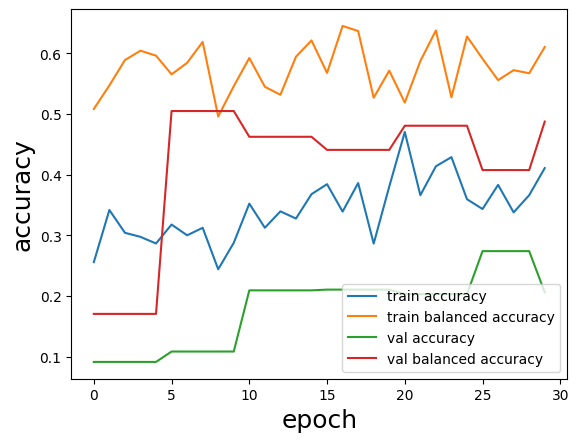

In [26]:
train_losses = np.stack([stat["trainloss"] for stat in stats])
train_accuracy = np.stack([stat["train_balanced_acc"] for stat in stats])
train_bal_accuracy = np.stack([stat["trainaccuracy"] for stat in stats])
val_accuracy = np.stack([stat["val_balanced_acc"] for stat in stats])
val_bal_accuracy = np.stack([stat["valaccuracy"] for stat in stats])
epoch = np.stack([stat["epoch"] for stat in stats])

fig, ax = plt.subplots()
ax.plot(epoch, train_accuracy, label="train accuracy")
ax.plot(epoch, train_bal_accuracy, label="train balanced accuracy")
ax.plot(epoch, val_accuracy, label="val accuracy")
ax.plot(epoch, val_bal_accuracy, label="val balanced accuracy")
ax.legend()
ax.set_xlabel("epoch", fontsize=18)
ax.set_ylabel("accuracy", fontsize=18)
fig.savefig('train_accuracy_weighted'+'.pdf', format='pdf', bbox_inches = 'tight')

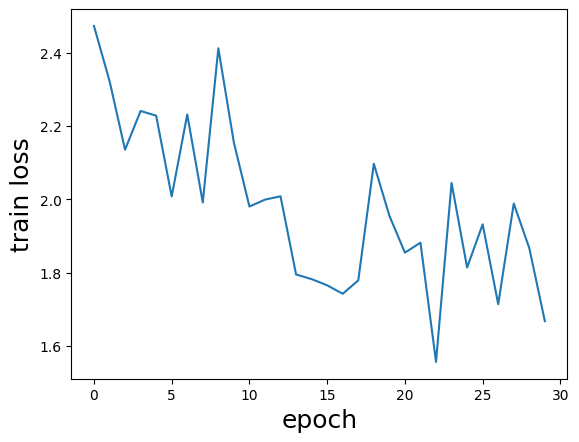

In [23]:
fig, ax = plt.subplots()
ax.plot(epoch, train_losses)
ax.set_xlabel("epoch", fontsize=18)
ax.set_ylabel("train loss", fontsize=18)
fig.savefig('train_loss_weighted'+'.pdf', format='pdf', bbox_inches = 'tight')

In [24]:
def print_confusion_matrix(prediction, ground_truth, save_name='train_confusion_matrix'):
    labels_in_data = []
    for key in FloodData.LABEL_CLASSES.keys():
        if FloodData.LABEL_CLASSES[key] in ground_truth:
            labels_in_data.append(key)

    cm = confusion_matrix(y_true=ground_truth, y_pred=prediction)
    fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap="Blues", class_names=labels_in_data)
    plt.xlabel('Predicted label', fontsize=18)
    plt.ylabel('True label', fontsize=18)
    fig.savefig(save_name+'.pdf', format='pdf', bbox_inches = 'tight')

Intersection over union: [0.         0.         0.13735654 0.         0.2388411  0.21398296
 0.0387542  0.         0.         0.61642177], mIoU: 0.12453565589995796


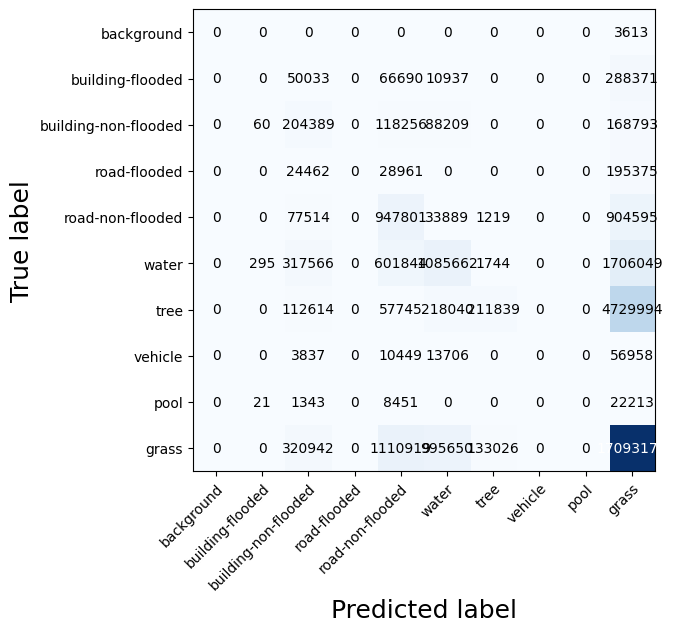

In [30]:
train_pred_new = np.concatenate(np.concatenate(train_pred))
train_ground_truth_new = np.concatenate(np.concatenate(train_ground_truth))

IoU = jaccard_score(y_true=train_ground_truth_new, y_pred=train_pred_new, average=None)
print_confusion_matrix(train_pred_new, train_ground_truth_new)
print(f"Intersection over union: {IoU}, mIoU: {IoU.mean()}")

In [29]:
val_pred, val_ground_truth = validation(val_dl, model, criterion, returning="predictions")

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 8 and the array at index 7 has size 4

In [ ]:
print_confusion_matrix(val_pred, val_ground_truth, save_name='validation_confusion_matrix')